<a href="https://colab.research.google.com/github/ZacharyXue/Code-Backup/blob/main/K%E8%BF%91%E9%82%BB%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
from collections import Counter
import random

# 2.1 k近邻算法概论

给定测试样本，基于某种距离度量找出训练集中与其最接近的k个训练样本，然后基于这k个样本信息对测试样本进行预测。通常，在分类任务中使用投票法，在回归任务中使用平均法。

k-近邻没有显式的学习过程。

## 距离模型

两个实例点之间的相似度是用距离来进行衡量的，k近邻更多使用欧氏距离进行衡量，但也可以用其他距离进行衡量。

设特征空间$\chi$是n为实数向量空间$R^n$，$x_i,x_j \in \chi$，$x_i=(x_i^1,x_i^2,...,x_i^n)^T$，$x_j=(x_j^1,x_j^2,...,x_j^n)^T$，则$x_i,x_j$的$L_p$距离定义为：
$$L_p(x_i.x_j)=( \sum_{l=1}^n |x_i^l-x_j^l|^p)^{\frac{1}{p}}
$$
上式中$p \ge 0$。当$p=2$时，称为欧氏距离；当$p=1$时，称为曼哈顿距离；当$p=\infty$时，表示各坐标距离最大值。

创建数据集：

In [ ]:
def createDataSet():
  group = np.array([[1,101],[5,89],[108,5],[115,8]])
  labels = ['爱情片','爱情片','动作片','动作片']
  return group,labels

if __name__ == '__main__':
  group,labels = createDataSet()
  print(f'group is {group}, and labels is {labels}')

group is [[  1 101]
 [  5  89]
 [108   5]
 [115   8]], and labels is ['爱情片', '爱情片', '动作片', '动作片']


## k近邻函数

在写k近邻时候用到的numpy函数：

[`numpy.tile(A, reps)`](https://numpy.org/doc/stable/reference/generated/numpy.tile.html)：Construct an array by repeating A the number of times given by reps.

[`numpy.argsort(a, axis=-1, kind=None, order=None)`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html?highlight=argsort#numpy.argsort)：Returns the **indices** that would sort an array.

用到的Python函数：

[`dict.get(key[, default])`](https://docs.python.org/3/library/stdtypes.html?highlight=get#dict.get)：Return **the value for key** if key is in the dictionary, else **default**. If default is not given, it defaults to None, so that this method never raises a KeyError.

用到的operator函数：

[`operator.itemgetter(*items)`](https://docs.python.org/3/library/operator.html?highlight=operator%20itemgetter#operator.itemgetter)：Return a callable object that fetches item from its operand **using the operand’s `__getitem__()` method**. If multiple items are specified, returns a tuple of lookup values. For example:

- After f = itemgetter(2), the call f(r) returns r[2].

- After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3]).

用到的collections函数：

[`collections.Counter([iterable-or-mapping])`](https://docs.python.org/3/library/collections.html?highlight=counter#collections.Counter)：A Counter is a **dict subclass** for counting hashable objects. It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values. Counts are allowed to be any integer value including zero or negative counts. 

这里使用的是其`most_common()`函数，范例如下：
```python
>>> Counter('abracadabra').most_common(3)
[('a', 5), ('b', 2), ('r', 2)]
```

In [17]:
def classify0(inX,dataSet,labels,k):
  # 找到数据集尺寸
  dataSetSize = dataSet.shape[0]
  # 计算input和数据集中各样本距离
  diffMat = np.tile(inX,(dataSetSize,1)) - dataSet
  sqDiffMat = diffMat ** 2
  distances = sqDiffMat.sum(axis=1) ** 0.5
  # 获得距离从小到大排列下的index值
  sortedDistIndices = distances.argsort()
  # 初始化计数器，然后对距离最近的k个样本进行统计
  counts = Counter()
  for i in range(k):
    counts[labels[sortedDistIndices[i]]] += 1
  return counts.most_common()[0][0]

In [ ]:
if __name__ == '__main__':
  # 创建样本集
  group, labels = createDataSet()
  # 创建测试样本
  test = [101,20]
  test_class = classify0(test, group, labels, 3)
  print(test_class)

动作片


# 2.2 k-近邻算法实战之约会网站配对效果判定



## [数据集处理](https://raw.githubusercontent.com/Jack-Cherish/Machine-Learning/master/kNN/2.%E6%B5%B7%E4%BC%A6%E7%BA%A6%E4%BC%9A/datingTestSet.txt)

以下代码用于将google云盘中的数据集载入到colab中，参考见[链接](https://zhuanlan.zhihu.com/p/54389036)。

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
import sys
os.chdir('drive/Colab Notebooks/机器学习实战')

然后进行数据处理

In [25]:
def file2matrix(filename):
  # 所参考文档没有使用with打开，貌似不是很规范
  with open(filename,'r') as f:
    lines = f.readlines()
    cloumns = len(lines)
    # 这里要注意列数的获取，因为原数据是字符串，
    # 如果直接求的话只会得到字符串长度，故需要进行简单处理
    rows = len(lines[0].strip().split('\t'))
    # 这里先初始化numpy矩阵的原因应该是numpy矩阵append不好操作，concatenate？
    returnMatrix = np.zeros((cloumns,rows - 1))
    labelArray = []
    for i,line in enumerate(lines):
      temp = line.strip().split('\t')
      # 获得input
      returnMatrix[i,:] = temp[:3]
      # 获得label
      if temp[-1] == 'didntLike':
        labelArray.append(1)
      elif temp[-1] == 'smallDoses':
        labelArray.append(2)
      elif temp[-1] == 'largeDoses':
        labelArray.append(3)
    labelArray = np.array(labelArray)
  return returnMatrix,labelArray


测试

In [8]:
if __name__ == '__main__':
    #打开的文件名
    filename = "datingTestSet.txt"
    #打开并处理数据
    datingDataMat, datingLabels = file2matrix(filename)
    print(datingDataMat.shape)

(1000, 3)


## 数据归一化

这里归一化使用的是:(data - min)/(max - min)

In [ ]:
def autoNorm(dataSet):
  #获得数据的最小值
  minVals = dataSet.min(0)
  maxVals = dataSet.max(0)
  #最大值和最小值的范围
  ranges = maxVals - minVals
  #shape(dataSet)返回dataSet的矩阵行列数
  normDataSet = np.zeros(np.shape(dataSet))
  #返回dataSet的行数
  m = dataSet.shape[0]
  #原始值减去最小值
  normDataSet = dataSet - np.tile(minVals, (m, 1))
  #除以最大和最小值的差,得到归一化数据
  normDataSet = normDataSet / np.tile(ranges, (m, 1))
  #返回归一化数据结果,数据范围,最小值
  return normDataSet, ranges, minVals

我尝试使用(data-average)/std来进行归一化操作。顺便贴下关于归一化的几种类型：

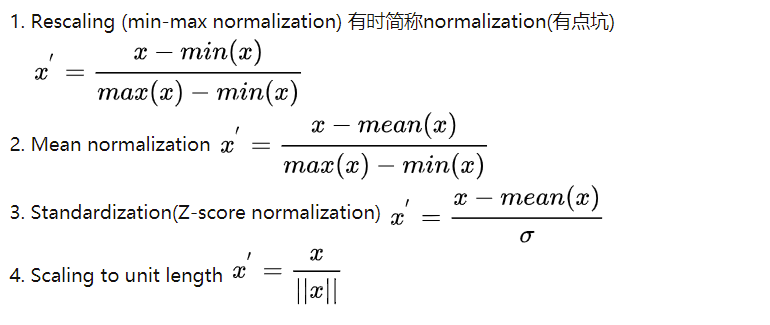

除此，作者原代码都没有利用广播机制，显得程序很繁杂，我写的时候还是尽量使用广播机制吧。

In [26]:
def autoNorm(dataSet):
  # 获得数组平均值
  averageVals = np.average(dataSet,axis=0)
  # 获得数组标准差
  stdVals = np.std(dataSet,axis=0)
  # 获得归一化结果
  normDataSet = (dataSet - averageVals)/stdVals
  return normDataSet,stdVals,averageVals

测试：

In [27]:
#打开的文件名
filename = "datingTestSet.txt"
#打开并处理数据
datingDataMat, datingLabels = file2matrix(filename)
normDataSet, std, average = autoNorm(datingDataMat)
print(normDataSet.shape)
print(std.shape)
print(average.shape)

(1000, 3)
(3,)
(3,)


## 测试算法

In [ ]:
def datingClassTest():
  #打开的文件名
  filename = "datingTestSet.txt"
  #将返回的特征矩阵和分类向量分别存储到datingDataMat和datingLabels中
  datingDataMat, datingLabels = file2matrix(filename)
  #取所有数据的百分之十
  hoRatio = 0.10
  #数据归一化,返回归一化后的矩阵,数据范围,数据最小值
  normMat, ranges, minVals = autoNorm(datingDataMat)
  #获得normMat的行数
  m = normMat.shape[0]
  #百分之十的测试数据的个数
  numTestVecs = int(m * hoRatio)
  #分类错误计数
  errorCount = 0.0

  for i in range(numTestVecs):
      #前numTestVecs个数据作为测试集,后m-numTestVecs个数据作为训练集
      classifierResult = classify0(normMat[i,:], normMat[numTestVecs:m,:],
          datingLabels[numTestVecs:m], 4)
      print("分类结果:%d\t真实类别:%d" % (classifierResult, datingLabels[i]))
      if classifierResult != datingLabels[i]:
          errorCount += 1.0
  print("错误率:%f%%" %(errorCount/float(numTestVecs)*100))

原代码是直接将前面10%作为测试集后面的作为“训练集”，这种做法实际上稍微有些不妥，所以我这里shuffle一下。

另，我以为shuffle是返回列表，结果是在原列表上操作……

In [47]:
def datingClassTest():
  #打开的文件名
  filename = "datingTestSet.txt"
  #将返回的特征矩阵和分类向量分别存储到datingDataMat和datingLabels中
  datingDataMat, datingLabels = file2matrix(filename)
  #取所有数据的百分之十
  hoRatio = 0.10
  #数据归一化,返回归一化后的矩阵,数据范围,数据最小值
  normMat, ranges, minVals = autoNorm(datingDataMat)
  # 为打散数据集，获得打散后的index
  m = normMat.shape[0]
  indices = list(range(m))
  random.shuffle(indices)
  #百分之十的测试数据的个数
  numTestVecs = int(m * hoRatio)
  #分类错误计数
  errorCount = 0.0
  for i in range(numTestVecs):
    classifierResult = classify0(normMat[indices[i],:],normMat[indices[numTestVecs:],:],datingLabels[indices[numTestVecs:]],5)
    if classifierResult != datingLabels[indices[i]]:
          errorCount += 1.0
  print("错误率:%f%%" %(errorCount/float(numTestVecs)*100))

In [48]:
datingClassTest()

错误率:3.000000%


# 2.3 kd树

k近邻算法要考虑的主要问题时如何对训练数据进行快速的k近邻搜索，尤其是当数据集比较庞大的时候再利用上述对全部样本计算是不太现实的。

故引入了kd树。kd树是二叉树，其是对样本的k维空间进行划分，然后形成一系列k维超矩阵区域。详细的介绍在李航《统计学习方法》P53.

对于kd树的搜索，写的比较详细的是[2 KD-Tree的构造与搜索](https://juejin.cn/post/6844904194487353357)。其搜索过程简单讲就是对二叉树进行搜索的过程，不一样的是kd树需要做的是找到一个距离最近的k个样本。

参考[2 KD-Tree的构造与搜索](https://juejin.cn/post/6844904194487353357)写kd树代码，顺便进一步了解kd树。

创建二叉树类：

In [51]:
class Node:
  def __init__(self,data,depth=0,lchild=None,rchild=None):
    self.data = data
    self.depth = depth
    self.lchild = lchild
    self.rchild = rchild

构建kd树

In [55]:
class KdTree():
  def __init__(self):
    # 根节点
    self.kdTree = None
    # axis的最大值
    self.n = 0
    # 
    self.nearest = None
  # 搭建kd树结构
  def create(self,dataSet,depth=0):
    if dataSet:
      m,n = dataSet.shape
      # 计算分割的维度
      self.n = n
      axis = depth % self.n
      # 找到中位数坐标
      mid = m // 2
      # 按照第几个维度（列）进行排序
      dataSetcopy = sorted(dataSet, key=lambda x: x[axis])
      # KD结点为中位数的结点，树深度为depth
      node = Node(dataSetcopy[mid], depth)
      if depth == 0:
          self.KdTree = node
      # 前mid行为左子结点，此时行数m改变，深度depth+1，axis会换个维度
      node.lchild = self.create(dataSetcopy[:mid], depth+1)
      node.rchild = self.create(dataSetcopy[mid+1:], depth+1)
      return node
    else:
      return None
  # 搜索kd树
  def search(self,x,count=1):
    nearest = []
    for i in range(count):
      nearest.append([-1, None])
      self.nearest = np.array(nearest)

      def recurve(node):
        """内方法，负责查找count个近邻点"""
        if node:
          # 步骤1：怎么找叶子节点
          # 在哪个维度的分割线，0,1,0,1表示x,y,x,y
          axis = node.depth % self.n
          # 判断往左走or右走，递归，找到叶子结点
          daxis = x[axis] - node.data[axis]
          if daxis < 0:
            recurve(node.lchild)
          else:
            recurve(node.rchild)

          # 步骤2：满足的就插入到近邻点集合中
          # 求test点与此点的距离
          dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(x, node.data)))
          # 遍历k个近邻点，如果不满k个，直接加入，如果距离比已有的近邻点距离小，替换掉，距离是从小到大排序的
          for i, d in enumerate(self.nearest):
            if d[0] < 0 or dist < d[0]:
              self.nearest = np.insert(self.nearest, i, [dist, node], axis=0)
              self.nearest = self.nearest[:-1]
              break

          # 步骤3：判断与垂线的距离，如果比这大，要查找垂线的另一侧
          n = list(self.nearest[:, 0]).count(-1)
          # -n-1表示不为-1的最后一行，就是记录最远的近邻点（也就是最大的距离）
          # 如果大于到垂线之间的距离，表示垂线的另一侧可能还有比他离的近的点
          if self.nearest[-n-1, 0] > abs(daxis):
            # 如果axis < 0，表示测量点在垂线的左侧，因此要在垂线右侧寻找点
            if daxis < 0:
              recurve(node.rchild)
            else:
              recurve(node.lchild)